In [ ]:
! pip install pennylane
! pip install pennylane-qiskit
! pip install keras==2.15.0

# Import Section

In [26]:
print("Kernel Started")

Kernel Started


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns
import cv2
import pennylane as qml

from tensorflow.keras import layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [28]:
keras.__version__

'2.15.0'

# Dataset Section

In [29]:
LabelledDataset = tf.keras.preprocessing.image_dataset_from_directory("/kaggle/input/rice-leaf-disease-image",
    shuffle=True,
    image_size=(320,320),
    batch_size=32,
    labels="inferred",
                                                                      
)

Found 5932 files belonging to 4 classes.


In [30]:
class_names = LabelledDataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

In [31]:
# for image_batch, labels_batch in LabelledDataset.take(1):
#     print(image_batch.shape)
#     print(labels_batch)

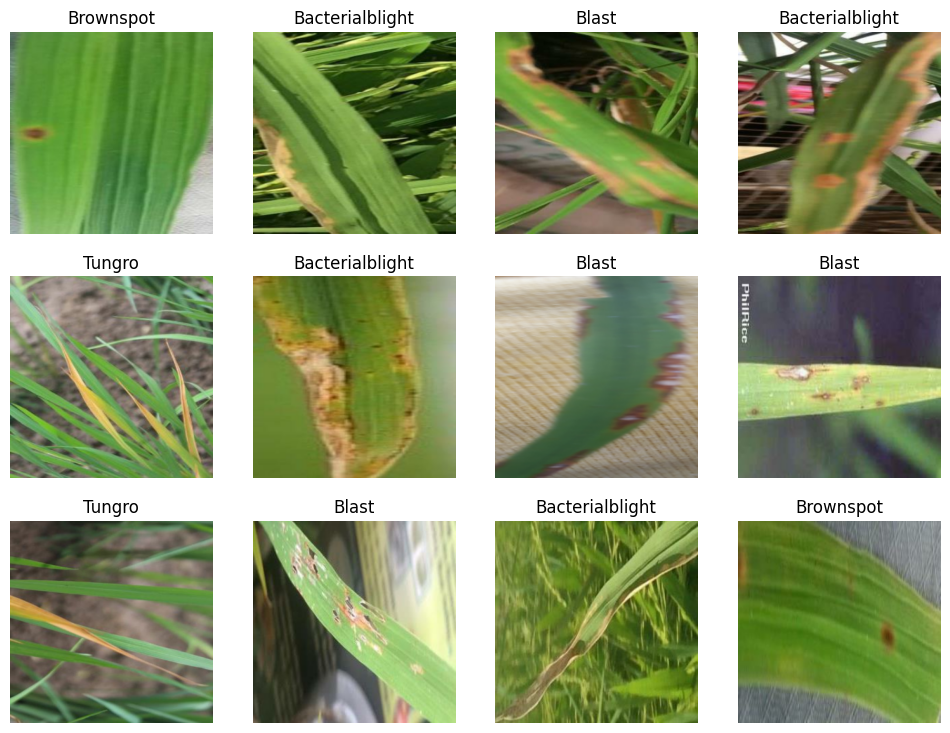

In [32]:
plt.figure(figsize=(12,9))
for image_batch, label_batch in LabelledDataset.take(2):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## Data Preparation

In [33]:
# label_data_dir ='/kaggle/input/rice-diseases-image-dataset/LabelledRice/Labelled'
train_data_dir = '/kaggle/input/rice-leaf-disease-image'
# val_data_dir = '/kaggle/input/rice-diseases-image-dataset/RiceDiseaseDataset/validation'
# test_data_dir = '/kaggle/input/rice-diseases-image-dataset/LabelledRice/Labelled'
# healthy_dir = '/kaggle/input/rice-diseases-image-dataset/LabelledRice/Labelled/Healthy'
img_height = 300
img_width = 300
batch_size = 32
num_classes = 4 #Default, don't change this value

In [34]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.3,
  subset="training",
  seed=257,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
class_names = train_ds.class_names

Found 5932 files belonging to 4 classes.
Using 4153 files for training.


In [35]:
# val_batches = tf.data.experimental.cardinality(train_ds)
# train_ds = val_ds.take((2*val_batches) // 3)
# val_ds = val_ds.skip((2*val_batches) // 3)

In [36]:
# healthy_dir = '/kaggle/input/rice-diseases-image-dataset/LabelledRice/Labelled/Healthy'
# healthy_ds = tf.keras.utils.image_dataset_from_directory(
#     healthy_dir,
#     validation_split=0.5,
#     subset="training",
#     seed=257,
#     image_size=(img_height, img_width),
#     batch_size=batch_size,
#     labels=None,
# )

In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.3,
  subset="validation",
  seed=257,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 5932 files belonging to 4 classes.
Using 1779 files for validation.


In [38]:
val_batches = tf.data.experimental.cardinality(val_ds)
testing_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [39]:
class_names = train_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

(300, 300, 3)


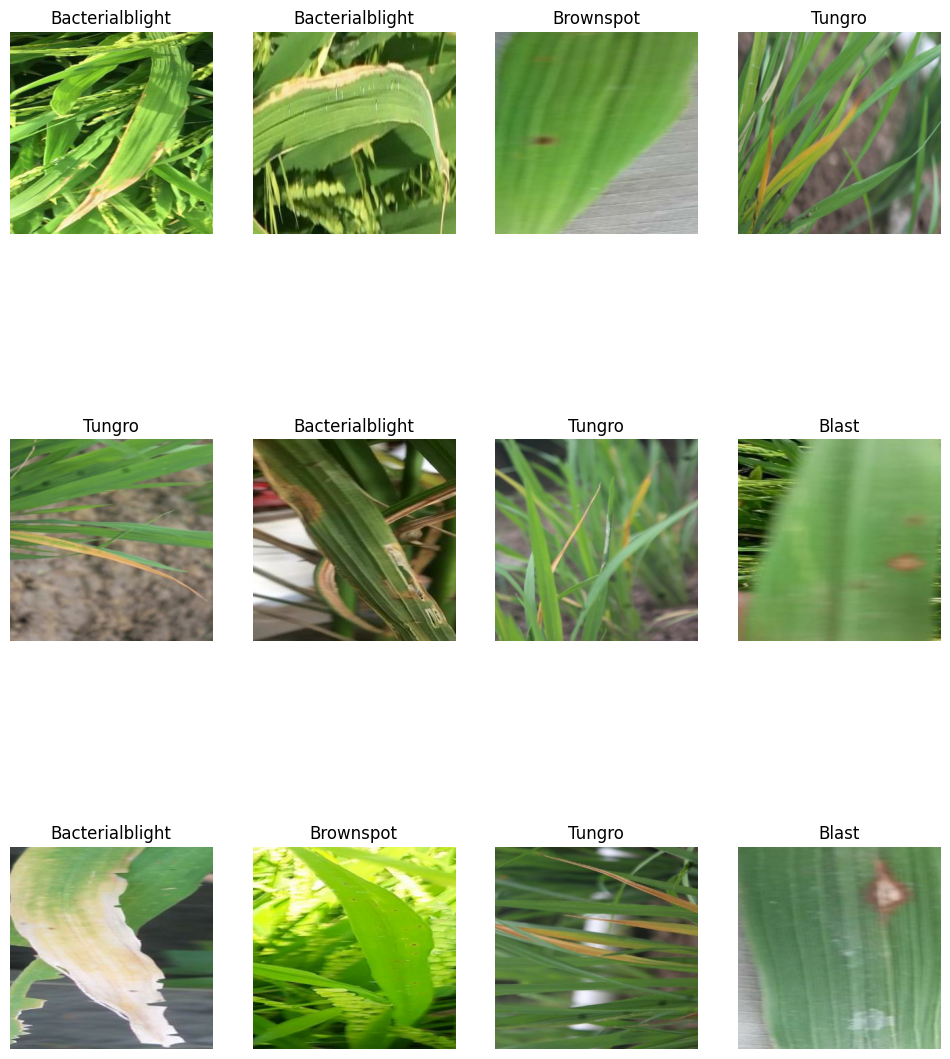

In [40]:
plt.figure(figsize=(12,15))
for image_batch, label_batch in train_ds.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
print(image_batch[i].shape)

# Model Design Section

In [41]:
def Load_Classical_Model(Classical_Model,
                         img_height = img_height,
                         img_width = img_width
                        ):
    '''
    Pilihan Classical_Model adalah ResNet, EfficientNet dan MobileNet
    Jika memilih ResNet, maka akan load model ResNet
    '''
    try:     
            if Classical_Model.lower() == 'resnet':
                base_model = keras.applications.ResNet50(weights='imagenet',
                                                       include_top = False,
                                                       input_shape=(img_height, img_width, 3)
                                                    )
                #Freezing the base model
                base_model.trainable = False
            elif Classical_Model.lower() == 'efficientnet':
                base_model = keras.applications.EfficientNetV2S(weights='imagenet',
                                                   include_top = False,
                                                   input_shape=(img_height, img_width, 3)
                                                )
                #Freezing the base model
                base_model.trainable = False
            elif Classical_Model.lower() == 'mobilenet':
                base_model = keras.applications.MobileNetV2(weights='imagenet',
                                                   include_top = False,
                                                   input_shape=(img_height, img_width, 3)
                                                )
                #Freezing the base model
                base_model.trainable = False
            elif Classical_Model.lower() == 'vgg16':
                base_model = keras.applications.VGG16(weights='imagenet',
                                                   include_top = False,
                                                   input_shape=(img_height, img_width, 3)
                                                )
                #Freezing the base model
                base_model.trainable = False
                
            elif Classical_Model.lower() == 'vanilla':
                base_model = keras.Sequential([
                    keras.Input(shape=(img_height, img_width,3)),
                    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
                    layers.GlobalAvgPool2D()
                ])
                base_model.summary()
            else:
                raise NameError('base_model tidak ditemukan')

            print(f"Success to load {Classical_Model} model, with input shape ({img_height,img_width})")
    except NameError as e:
        print(e)
        base_model = None
    finally:
        return  base_model
  

In [42]:
def Quantumlayer(n_qubits, n_layers):
    '''
    Membuat quantum layer dengan input n_qubits dan n_layers
    !Perlu diperhatikan terkait hubungan layer sebelum QuantumLayer
    output layer sebelumnya harus <= 2**n_qubits agar tidak terjadi eror embedding 
    
    return Qlayer : keras.layer
    '''
    inputs = 2**n_qubits
    
    weight_shapes = {"weights": (n_layers, n_qubits,3)}
    inputs = np.random.random(2**n_qubits)
    weights = np.random.random((n_layers,n_qubits,3))
    
    #Construct the quantum circuit
    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev)
    def HybridNode(inputs, weights):
        qml.AmplitudeEmbedding(inputs, pad_with = 0, wires=range(n_qubits) , normalize=True)
    #     qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    
    print(qml.draw(HybridNode, expansion_strategy="device")(inputs,weights))
    print(HybridNode(inputs, weights), "\n")
    
    #Make the quantum cirucit become quantum layer with keras extension
    qlayer = qml.qnn.KerasLayer(HybridNode,
                                weight_shapes,
                                output_dim=n_qubits,
                                name = "QuantumLayer")
    return qlayer

In [43]:
class ZeroMatrixHandlerLayer(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-8, name='ZeroHandleLayer', **kwargs):
        super(ZeroMatrixHandlerLayer, self).__init__(name=name, **kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        is_zero_matrix = tf.reduce_all(tf.equal(inputs, 0.0), axis=-1, keepdims=True)
        outputs = tf.where(is_zero_matrix, tf.ones_like(inputs)*self.epsilon, inputs)
        return outputs

In [44]:
def ConstructModel(Classic_Model, QuantumMode = False):
    
    
    """
    1. Pilih Model PreTrained : EfficientNet, ResNet, MobileNet
    2. Pilih Mode Quantum atau Classic
    3. Jika Quantum, maka mengonstruksi quantum circuit
    
    """
    base_model = Load_Classical_Model(Classic_Model,img_height,img_width)
    
    if QuantumMode == True:
        qlayer = Quantumlayer(n_qubits, n_layers)
        if Classic_Model.lower() == 'vanilla':
            model = tf.keras.Sequential([
                keras.Input(shape=(img_height, img_width,3)),
                base_model,
                qlayer,
                tf.keras.layers.Dense(4, activation='softmax')
            ])
        else:
            model = tf.keras.Sequential([
                base_model,
                keras.layers.Conv2D(512,kernel_size = (5,5), activation='relu'),
                tf.keras.layers.GlobalAveragePooling2D(),
                keras.layers.Dense(256, activation='relu'),
                ZeroMatrixHandlerLayer(),
                qlayer,
                tf.keras.layers.Dense(4, activation='softmax')
            ])
            model.summary()
            
            #Construct the Hybrid QCNN
    #         model = tf.keras.models.Sequential([
    #             base_model,
    #             keras.layers.Conv2D(64,7, activation='relu'),
    # #             keras.layers.Conv2D(64,3, activation='relu'),
    #             keras.layers.Flatten(),
    #             qlayer,
    #             keras.layers.Dense(num_classes, activation = "softmax")
    #         ])
    else:
        if Classic_Model.lower() == 'vanilla':
            model = tf.keras.Sequential([
                keras.Input(shape=(img_height, img_width,3)),
                base_model,
                tf.keras.layers.Dense(4, activation='softmax')
            ])
        else:        
            model = tf.keras.Sequential([
                keras.Input(shape=(img_height, img_width,3)),
                base_model,
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(4, activation='softmax')
            ])
        
#         model = keras.Sequential([
#             base_model,
# #             keras.layers.Conv2D(128,3, activation='relu'),
#             keras.layers.Conv2D(64,7, activation='relu'),
#             keras.layers.Flatten(),
# #             keras.layers.GlobalAveragePooling2D(),
# #             keras.layers.Dropout(Dropout_rate),
#             keras.layers.Dense(num_classes, activation = "softmax")
#         ])
    model.summary()    
    return model

In [45]:
def plotResult(modelhistory):
    plt.figure(figsize = [15,4])
    plt.subplot(1,2,1)
    # Plot the history of accuracy
    plt.plot(modelhistory.history['accuracy'])
    plt.plot(modelhistory.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    # plt.show()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(modelhistory.history['loss'])
    plt.plot(modelhistory.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    name_fig = '/kaggle/working/check_point/Train_val_graphic_'+str(model_name)+'.png'
    plt.savefig(name_fig) #must be placed before the show T_T
    plt.show()

In [46]:
def printRecord(modelhistory,elapsed):
    print("*"*17,"Record","*"*17, "\n\n")
    print(f"PreTrained Model \t: {PreTrained}")
    print(f"Learning rate \t\t: {lr}")
    print(f"Quantum_mode \t\t: {Quantum_mode}")
    print(f"Dropout_rate \t\t : {Dropout_rate}")
    print(f"Optimizer \t\t :{Opt}")
    print(f"Number of qubits \t: {n_qubits}\n Number of qlayer \t: {n_layers}")
    print(f"Training Accuracy \t : \t {modelhistory.history['accuracy'][-1]} \n")
    print(f"Validation Accuracy\t : \t {modelhistory.history['val_accuracy'][-1]} \n")
    print(f"Training Loss\t\t : \t {modelhistory.history['loss'][-1]} \n")
    print(f"Validation Loss\t\t : \t {modelhistory.history['val_loss'][-1]} \n") 
    print(f"Total Time Training \t : \t {elapsed} s")

# Model Training Section

You can choose one of these base_model : 
* resnet
* mobilenet
* efficientnet
* vgg16


In [54]:
#to make recording easier, please change the number of run
run_number = '73'

#Parameter Tuning
epoch = 100
lr = 0.001

# optimizer = keras.optimizers.Adam(learning_rate=lr)
# Opt = keras.optimizers.Lion()
Opt = keras.optimizers.RMSprop()
PreTrained = 'vanilla'
Dropout_rate = None

#Quantum 
Quantum_mode = False
n_qubits = 8 #karena inputnya berupa data berukuran 28*28=784 >>> need 10 qubit
n_layers = 1 #Still don't have any reason for this one. 

print("successfully set parameters")

successfully set parameters


In [55]:
model = ConstructModel(Classic_Model = PreTrained, QuantumMode = Quantum_mode)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 149, 149, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 147, 147, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 73, 73, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 71, 71, 256)       295168    
                                                                 
 global_average_pooling2d_3  (None, 256)              

In [56]:
model.compile(
    optimizer=Opt,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [57]:
t = time.time()
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds)
elapsed = time.time() - t

Fitting the top layer of the model
Epoch 1/100
130/130 [==============================] - 19s 122ms/step - loss: 6.7493 - accuracy: 0.3747 - val_loss: 3.1544 - val_accuracy: 0.4252
Epoch 2/100
130/130 [==============================] - 12s 94ms/step - loss: 2.0667 - accuracy: 0.4862 - val_loss: 9.5506 - val_accuracy: 0.2773
Epoch 3/100
130/130 [==============================] - 12s 95ms/step - loss: 1.8694 - accuracy: 0.5244 - val_loss: 17.3771 - val_accuracy: 0.3933
Epoch 4/100
130/130 [==============================] - 12s 96ms/step - loss: 2.1005 - accuracy: 0.5562 - val_loss: 27.2064 - val_accuracy: 0.4000
Epoch 5/100
130/130 [==============================] - 12s 95ms/step - loss: 3.3623 - accuracy: 0.5969 - val_loss: 29.1639 - val_accuracy: 0.6000
Epoch 6/100
130/130 [==============================] - 12s 96ms/step - loss: 2.9172 - accuracy: 0.6094 - val_loss: 51.2710 - val_accuracy: 0.2874
Epoch 7/100
130/130 [==============================] - 12s 96ms/step - loss: 2.9957 - accu

## Result

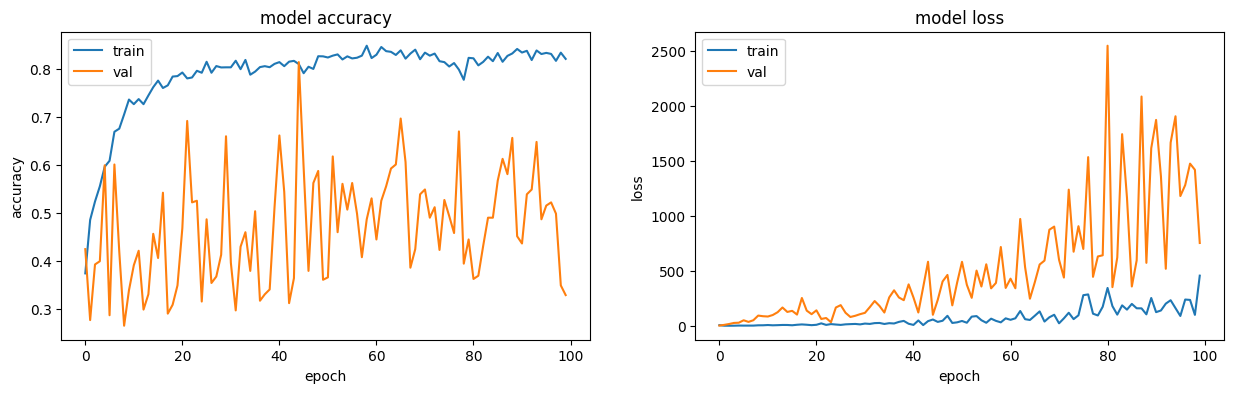

***************** Record ***************** 


PreTrained Model 	: vanilla
Learning rate 		: 0.001
Quantum_mode 		: False
Dropout_rate 		 : None
Optimizer 		 :<keras.src.optimizers.rmsprop.RMSprop object at 0x78371c891600>
Number of qubits 	: 8
 Number of qlayer 	: 1
Training Accuracy 	 : 	 0.821815550327301 

Validation Accuracy	 : 	 0.3294117748737335 

Training Loss		 : 	 456.3581848144531 

Validation Loss		 : 	 752.8076782226562 

Total Time Training 	 : 	 1249.977375984192 s


In [62]:
model_name =  str(PreTrained) +'_Q_'+str(Quantum_mode) + '_'+str(run_number)

model.save_weights('/kaggle/working/check_point/'+ str(model_name))
plotResult(history)
printRecord(history,elapsed)

In [63]:
Load_model = ConstructModel(Classic_Model = PreTrained, QuantumMode = Quantum_mode)

Load_model.load_weights('/kaggle/working/check_point/'+ str(model_name))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 149, 149, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 147, 147, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 73, 73, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 71, 71, 256)       295168    
                                                                 
 global_average_pooling2d_5  (None, 256)             

In [64]:
# print("Evaluate " + str(base_model_name) + "_Q" + str(n_qubits) + "C" + str(n_convpol))

test_predictions = []
test_labels = []
for data in testing_ds:
    preds = Load_model.predict(data[0]).argmax(axis=1)
    test_predictions.extend(preds)
    test_labels.extend(data[1].numpy())
test_labels = np.array(test_labels).flatten()
test_predictions = np.array(test_predictions).flatten()

print("Accuracy\t: ", accuracy_score(test_labels, test_predictions))
print("Precision\t: ", precision_score(test_labels, test_predictions,average='weighted'))
print("Recall\t\t: ", recall_score(test_labels, test_predictions,average='weighted'))
print("F1-score\t: ", f1_score(test_labels, test_predictions,average='weighted'))

1/1 [==============================] - 0s 55ms/step
Accuracy	:  0.33361486486486486
Precision	:  0.5606969239641874
Recall		:  0.33361486486486486
F1-score	:  0.24862205277337274


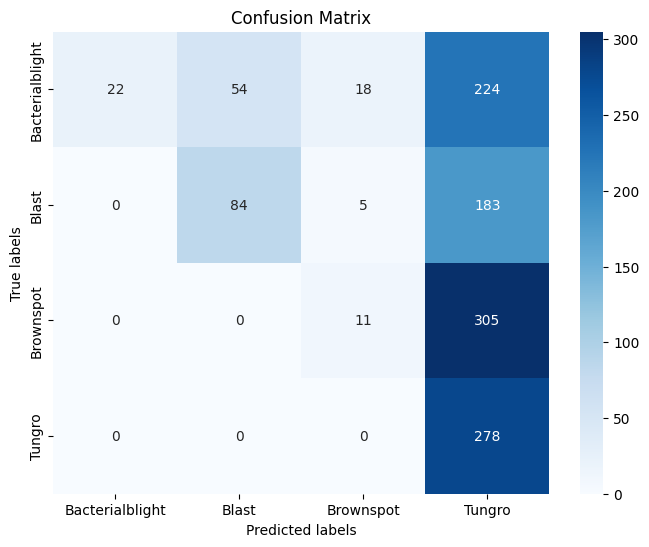

In [65]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
name_fig = '/kaggle/working/check_point/ConfusionMatrix'+str(PreTrained) +'Q_'+str(Quantum_mode)+'.png'
plt.savefig(name_fig) #must be placed before the show T_T
plt.show()